<table class="table table-bordered">
<tr>
<th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

In [1]:
# import the packages
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('DDPasg1').getOrCreate()
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.window import Window
from pyspark.sql import functions as F

## Problem Statement Formulation

In [2]:
# load and explore data

In [3]:
df_pyspark=spark.read.csv('./ddpasg1data/thailand_ppty_asg1.csv', header=True, inferSchema=True) # inferSchema auto detects data type

In [4]:
df_pyspark.show(5)

+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|  price|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-------+
|         For Sale|       76.86|              2|    Baht|         Condo|    9942777|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold|5500000|
|         For Sale|        42.0|              1|    Baht|         Condo|    9807686|    Dusit|      

In [5]:
df_pyspark.printSchema()

root
 |-- sub_property_type: string (nullable = true)
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



In [6]:
print("Number of Rows in df_pyspark:", df_pyspark.count())


Number of Rows in df_pyspark: 41360


 ## Problem Statement Formulation : Report

I successfully loaded the data from the Excel file into a PySpark DataFrame and conducted preliminary exploration. The dataset comprises 41,360 rows and 18 columns, each contributing valuable information for predicting Thailand property prices. The columns include sub-property type, living space, bathroom number, currency, property type, property ID, city, floor level, state, built year, latitude, premium, bedroom number, address, listing label, longitude, tenure, and price. This diverse set of columns provides a comprehensive foundation for building a robust predictive model. 

### Value Based Problem Statement

The primary objective is to create a reliable Price Prediction Model that brings significant value to individuals and organizations in the real estate market. By offering accurate property price forecasts, the model empowers buyers, sellers, and developers to make informed decisions, negotiate effectively, and identify strategic investment opportunities. Addressing complexities such as market dynamics and data variability, the model aims to enhance the efficiency and transparency of the Thailand real estate market. Success metrics include high accuracy, interpretability, and scalability, ensuring the model's adaptability to future market changes. Ultimately, this assignment seeks to contribute to the growth and competitiveness of the Thailand property sector, benefitting all stakeholders involved in property transactions.

## Exploratory Data Analysis and Data Cleansing

### Checking for Null Values

In [7]:
# Check for null values in each column
null_counts = df_pyspark.select([col(c).isNull().cast('int').alias(c) for c in df_pyspark.columns])

# Display the count of null values in each column
for column in df_pyspark.columns:
    null_count = null_counts.agg({column: 'sum'}).collect()[0][0]
    print(f"Column '{column}' has {null_count} null values.")

Column 'sub_property_type' has 0 null values.
Column 'living_space' has 50 null values.
Column 'bathroom_number' has 0 null values.
Column 'currency' has 0 null values.
Column 'property_type' has 0 null values.
Column 'property_id' has 0 null values.
Column 'city' has 0 null values.
Column 'floor_level' has 0 null values.
Column 'state' has 0 null values.
Column 'built_year' has 0 null values.
Column 'latitude' has 0 null values.
Column 'premium' has 0 null values.
Column 'bedroom_number' has 0 null values.
Column 'address' has 0 null values.
Column 'listing_label' has 0 null values.
Column 'longitude' has 0 null values.
Column 'tenure' has 0 null values.
Column 'price' has 0 null values.


### Viewing Data Types

In [8]:
column_types = df_pyspark.dtypes
numerical_cols = [col for col, dtype in column_types if dtype not in ('string', 'boolean')]
categorical_cols = [col for col, dtype in column_types if dtype in ('string', 'boolean')]

In [9]:
# Display the results
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['living_space', 'bathroom_number', 'property_id', 'floor_level', 'built_year', 'latitude', 'premium', 'bedroom_number', 'longitude', 'price']
Categorical Columns: ['sub_property_type', 'currency', 'property_type', 'city', 'state', 'address', 'listing_label', 'tenure']


### Exploring The Target Variable

In [10]:
price_stats = df_pyspark.describe('price').show()


+-------+-------------------+
|summary|              price|
+-------+-------------------+
|  count|              41360|
|   mean|  6610496.336532882|
| stddev|1.511423482610068E7|
|    min|                  0|
|    max|         1396396324|
+-------+-------------------+



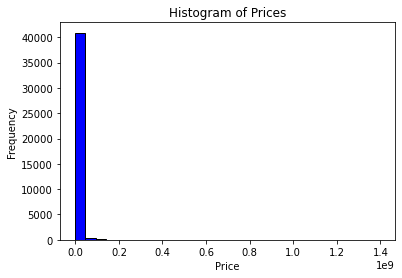

In [11]:
import matplotlib.pyplot as plt

# Assuming df_pyspark is your PySpark DataFrame
price_data = df_pyspark.select("price").rdd.flatMap(lambda x: x).collect()

# Plotting the histogram
plt.hist(price_data, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


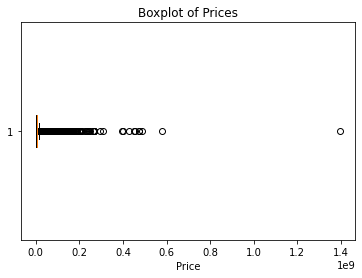

In [12]:
plt.boxplot(price_data, vert=False)
plt.title('Boxplot of Prices')
plt.xlabel('Price')
plt.show()

### Exploring Numerical Data

In [13]:
df_pyspark.select(numerical_cols).show(5)

+------------+---------------+-----------+-----------+----------+-----------+-------+--------------+-----------+-------+
|living_space|bathroom_number|property_id|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|  price|
+------------+---------------+-----------+-----------+----------+-----------+-------+--------------+-----------+-------+
|       76.86|              2|    9942777|          6|      2010|13.79101869|      0|             2|100.5162452|5500000|
|        42.0|              1|    9807686|          4|      2010|13.79101869|      0|             1|100.5162452|4100000|
|       123.0|              2|    8934387|          2|      2012|13.85948084|      0|             3|100.8482369|1650000|
|       180.0|              2|    9836450|          2|      2011|  13.859683|      0|             4| 100.857774|3650000|
|       35.35|              1|    9407447|         56|      2018|13.73158352|      0|             1|100.5311729|7850000|
+------------+---------------+--

#### Summary Statistics

In [14]:
from pyspark.sql.functions import mean, stddev

In [15]:
summary_stats = df_pyspark.describe(numerical_cols)

In [16]:
summary_stats.show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|summary|     living_space|   bathroom_number|       property_id|       floor_level|        built_year|          latitude|             premium|    bedroom_number|         longitude|              price|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+
|  count|            41310|             41360|             41360|             41360|             41360|             41360|               41360|             41360|             41360|              41360|
|   mean|131.2979258121521|1.2972678916827853| 9092960.425676983|15504.037693423597|2014.3418036750484|13.754093207736465|0.014192456479690523|1.2618471953578336| 100.5558954954391|  6610496.3

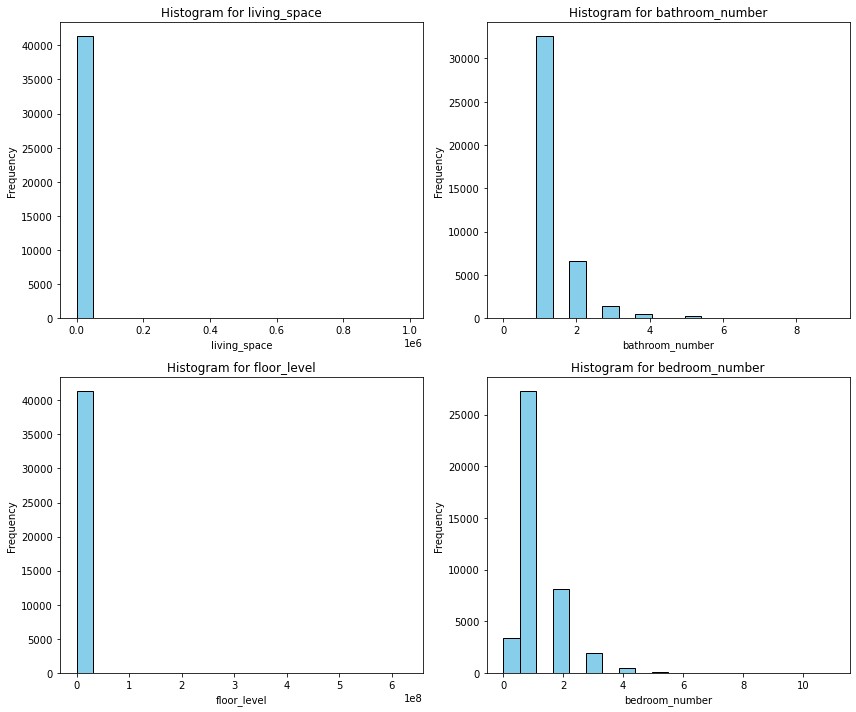

In [17]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

numerical_cols = ['living_space', 'bathroom_number', 'floor_level', 'bedroom_number']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot histograms for each numerical column
for i, col in enumerate(numerical_cols):
    # Filter out missing values (NoneType) and extract values from the PySpark DataFrame
    values = df_pyspark.select(col).na.drop().rdd.flatMap(lambda x: x).collect()
    
    # Plot histogram
    axes[i].hist(values, bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
numerical_columns = ['living_space', 'bathroom_number', 'floor_level', 'bedroom_number']

In [19]:
# Assuming df_pyspark is your DataFrame and numerical_columns is a list of numerical column names
from pyspark.sql.functions import skewness, kurtosis
for column in numerical_columns:
    # Calculate skewness and kurtosis for each numerical column
    skew_val = df_pyspark.agg(skewness(column)).collect()[0][0]
    kurt_val = df_pyspark.agg(kurtosis(column)).collect()[0][0]
    
    # Print the results
    print(f"Skewness of {column}: {skew_val}")
    print(f"Kurtosis of {column}: {kurt_val}")
    print("------------------------")

Skewness of living_space: 116.18150721571875
Kurtosis of living_space: 15583.608108066686
------------------------
Skewness of bathroom_number: 3.2249500580977313
Kurtosis of bathroom_number: 14.106485811667255
------------------------
Skewness of floor_level: 203.28383820745697
Kurtosis of floor_level: 41332.976375963604
------------------------
Skewness of bedroom_number: 1.776199054680757
Kurtosis of bedroom_number: 7.958018008862936
------------------------


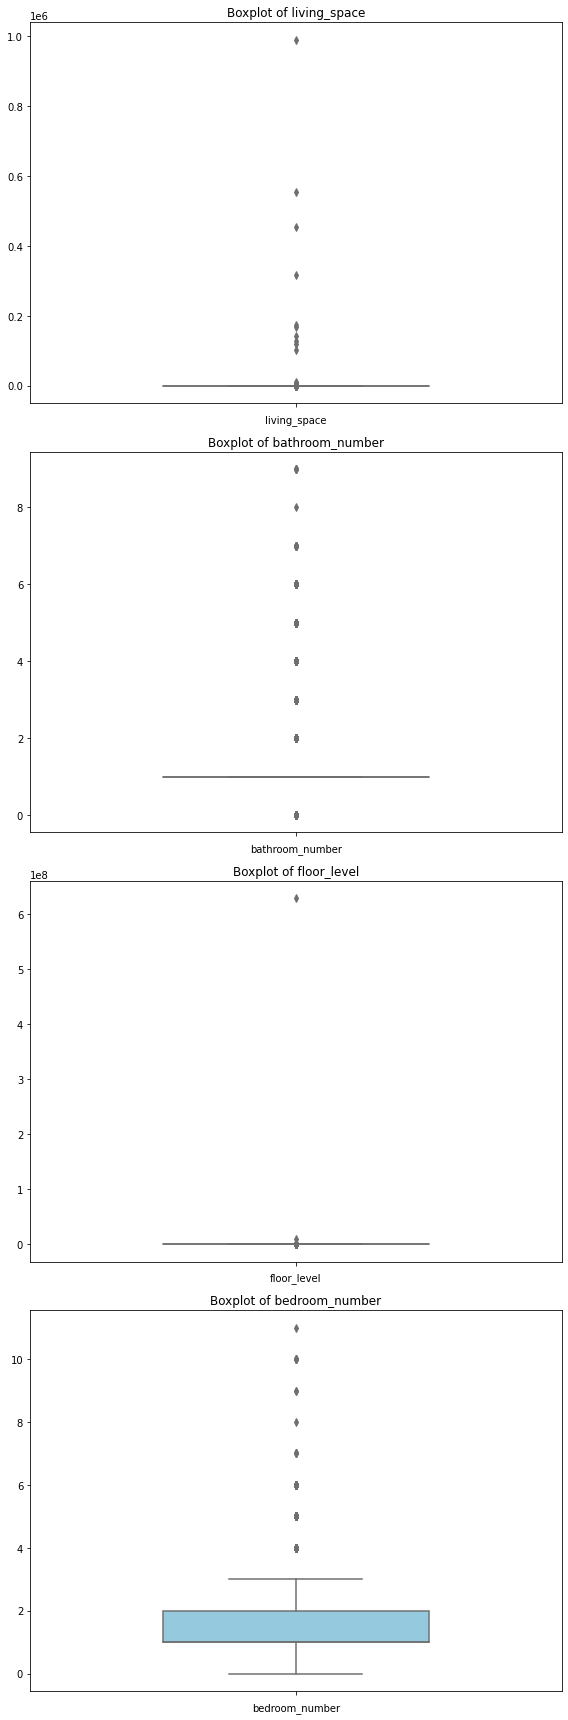

In [20]:
import seaborn as sns
from pyspark.sql.functions import col

# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(8, 6 * len(numerical_cols)))

# Plot boxplots for each numerical column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    
    # Extract values from the PySpark DataFrame and filter out null values
    values = df_pyspark.select(col).filter(col + " is not null").rdd.flatMap(lambda x: x).collect()
    
    # Plot boxplot with horizontal orientation
    sns.boxplot(y=values, ax=ax, color='skyblue', width=0.5)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()


#### Numerical Columns Relationship with Price

In [21]:

for column in numerical_cols:
    correlation = df_pyspark.select(column, 'price').corr(column, 'price')
    print(f"Correlation between {column} and price: {correlation}")


Correlation between living_space and price: 0.010981535704223977
Correlation between bathroom_number and price: 0.47008254484596457
Correlation between floor_level and price: -0.0012104086901564282
Correlation between bedroom_number and price: 0.38911363104128793


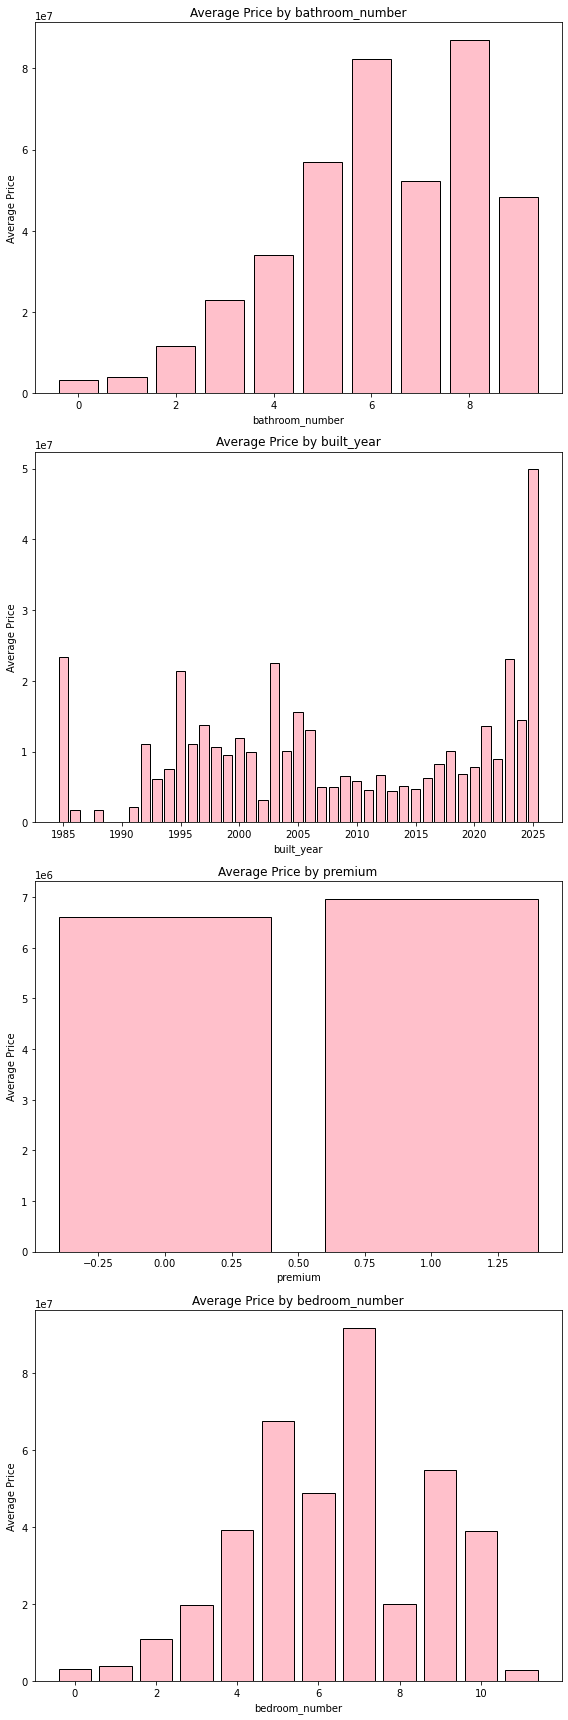

In [22]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

numerical_columns = ['bathroom_number', 'built_year', 'premium', 'bedroom_number']

# Calculate the average price for each numerical variable
average_prices = []

for col in numerical_columns:
    avg_price = df_pyspark.groupBy(col).agg(avg("price").alias("average_price"))
    # Sort by the numerical column
    avg_price = avg_price.sort(col)
    average_prices.append(avg_price)

# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), figsize=(8, 6 * len(numerical_columns)))

# Plot bar charts for each numerical column
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    # Extract values from the PySpark DataFrame and handle None values
    x_values = [float(row[col]) if row[col] is not None else 0 for row in average_prices[i].collect()]
    y_values = [float(row['average_price']) for row in average_prices[i].collect()]
    
    # Use Matplotlib to create bar plot
    ax.bar(x_values, y_values, color='pink', edgecolor='black')
    ax.set_title(f'Average Price by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Average Price')

# Adjust layout
plt.tight_layout()
plt.show()


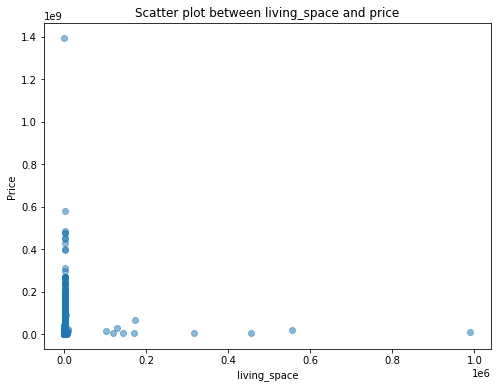

In [23]:
# Plot scatter plots
numerical_columns = ['living_space']

from pyspark.sql.functions import col
for col_name in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_pyspark.select(col(col_name)).collect(), df_pyspark.select("price").collect(), alpha=0.5)
    plt.title(f"Scatter plot between {col_name} and price")
    plt.xlabel(col_name)
    plt.ylabel("Price")
    plt.show()


### Exploring Categorical Data

In [24]:
df_pyspark.select(categorical_cols).show(5)

+-----------------+--------+--------------+---------+-------+--------------------+-------------+--------+
|sub_property_type|currency| property_type|     city|  state|             address|listing_label|  tenure|
+-----------------+--------+--------------+---------+-------+--------------------+-------------+--------+
|         For Sale|    Baht|         Condo|    Dusit|Bangkok|Samsen Road, Dusi...|       NORMAL|Freehold|
|         For Sale|    Baht|         Condo|    Dusit|Bangkok|Samsen Road, Dusi...|       NORMAL|Freehold|
|         For Sale|    Baht|Detached House|Nong Chok|Bangkok|Mit Maitri Road, ...|    CORPORATE|Freehold|
|         For Sale|    Baht|Detached House|Nong Chok|Bangkok|Soi Mitmaitri 2, ...|       NORMAL|Freehold|
|         For Sale|    Baht|         Condo| Bang Rak|Bangkok|- Rama 4 Road, Si...|    CORPORATE|Freehold|
+-----------------+--------+--------------+---------+-------+--------------------+-------------+--------+
only showing top 5 rows



#### Counts of Each Variable

In [25]:
from pyspark.sql.functions import countDistinct

for column in categorical_cols:
    # Use countDistinct to calculate the number of unique values in each column
    unique_count = df_pyspark.agg(countDistinct(column)).collect()[0][0]
    print(f"Number of unique values in {column}: {unique_count}")


Number of unique values in sub_property_type: 2
Number of unique values in currency: 1
Number of unique values in property_type: 4
Number of unique values in city: 89
Number of unique values in state: 17
Number of unique values in address: 1686
Number of unique values in listing_label: 3
Number of unique values in tenure: 3


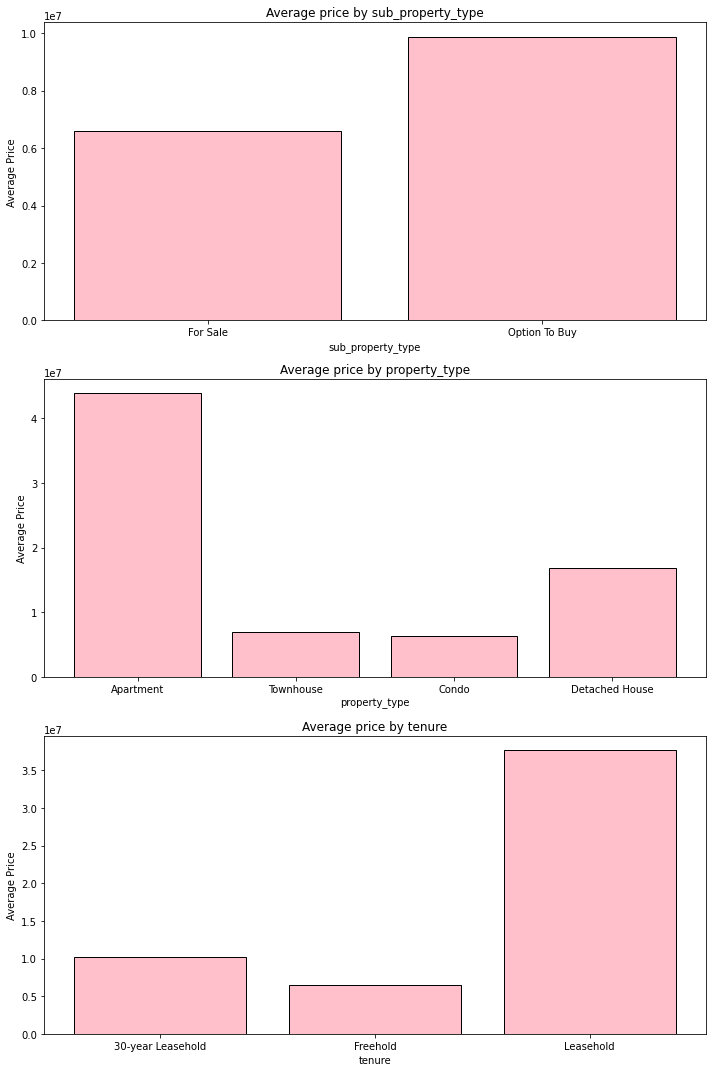

In [26]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# List of categorical columns
cat_columns = ['sub_property_type', 'property_type', 'tenure']

# Calculate the average price for each categorical variable
average_prices = []

for col in cat_columns:
    avg_price = df_pyspark.groupBy(col).agg(avg("price").alias("average_price"))
    average_prices.append(avg_price)

# Plotting
fig, axes = plt.subplots(nrows=len(cat_columns), figsize=(10, 5 * len(cat_columns)))

for i, (col, avg_price) in enumerate(zip(cat_columns, average_prices)):
    ax = axes[i] if len(cat_columns) > 1 else axes
    
    # Convert PySpark DataFrame to Pandas Series
    x_values = [str(row[col]) for row in avg_price.collect()]  # Convert to strings
    y_values = [float(row['average_price']) for row in avg_price.collect()]

    # Use Matplotlib to create bar plot
    ax.bar(x_values, y_values, color='pink', edgecolor='black')
    ax.set_title(f"Average price by {col}")
    ax.set_ylabel("Average Price")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()



### Grouping and Filtering

In [27]:
from pyspark.sql.functions import col
current_year = F.year(F.current_date())

# Define the threshold year for the last 10 years
threshold_year = current_year - 10

# Filter properties built in the last 10 years
df_last_10_years = df_pyspark.filter(col("built_year") >= threshold_year)

count_last_10_years = df_last_10_years.count()

print(f"Number of properties built in the last 10 years: {count_last_10_years}")



Number of properties built in the last 10 years: 30543


In [28]:
from pyspark.sql.functions import expr
ranges = [
    (0, 50),
    (51, 100),
    (101, 150),
    (151,200),
    (201,1000000000)
]
copy = df_pyspark
# Create a new column 'floor_level_range' based on the specified ranges
for start, end in ranges:
    copy = copy.withColumn(
        f"floor_level_{start}_{end}",
        expr(f"CASE WHEN floor_level BETWEEN {start} AND {end} THEN 'floor_level_{start}_{end}' ELSE NULL END")
    )

# Combine the range columns into a single column 'floor_level_range'
floor_range = copy.withColumn("floor_level_range", expr("CONCAT_WS(',', " + ", ".join([f"floor_level_{start}_{end}" for start, end in ranges]) + ")"))

# Group by the 'floor_level_range' and count
result = floor_range.groupBy("floor_level_range").count().orderBy("floor_level_range")

# Show the result
result.show(truncate=False)

+--------------------------+-----+
|floor_level_range         |count|
+--------------------------+-----+
|floor_level_0_50          |40306|
|floor_level_101_150       |59   |
|floor_level_151_200       |5    |
|floor_level_201_1000000000|205  |
|floor_level_51_100        |785  |
+--------------------------+-----+



In [29]:
# Filtering for Potential Errors
unrealistic_rows_bedroom = df_pyspark.filter((col("bedroom_number") >= 9))
unrealistic_rows_bedroom.show()

+-----------------+------------+---------------+--------+--------------+-----------+-----------+-----------+-------------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|       city|floor_level|        state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|
+-----------------+------------+---------------+--------+--------------+-----------+-----------+-----------+-------------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|         For Sale|      878.34|              9|    Baht|     Townhouse|    9123972|   Yan Nawa|          5|      Bangkok|      2016|  13.686206|      0|            10|Yan Nawa Road, Ch...|    CORPORATE| 100.537212|Freehold|85000000|
|         For Sale|       850.0|              9|    Baht|       

In [30]:

# Calculate the quartiles for floor_level
quantiles = df_pyspark.stat.approxQuantile("price", [0.25, 0.75], 0.01)

# Calculate the IQR for floor_level
lower_q, upper_q = quantiles
iqr = upper_q - lower_q

# Define a threshold for outlier detection
threshold = 100

# Flag rows with extreme outliers for floor_level
df_pyspark = df_pyspark.withColumn("priceoutlier", 
    (col("price") < lower_q - threshold * iqr) | (col("price") > upper_q + threshold * iqr)
)

# Show the flagged outliers for floor_level
df_pyspark.filter("priceoutlier").show()

+-----------------+------------+---------------+--------+-------------+-----------+-------------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+---------+----------+------------+
|sub_property_type|living_space|bathroom_number|currency|property_type|property_id|         city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|   tenure|     price|priceoutlier|
+-----------------+------------+---------------+--------+-------------+-----------+-------------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+---------+----------+------------+
|         For Sale|      709.42|              5|    Baht|        Condo|    9922189|   Khlong San|         51|Bangkok|      2018|13.72812789|      0|             4|117 Charoen Nakor...|    CORPORATE|100.5110346| Freehold| 485000000|        true|
|         For Sale| 

In [31]:

# Filter rows where 'price' is equal to 0
zero_price_rows = df_pyspark.filter(col("price") == 0)
print("Number of Rows with price 0 in df_pyspark:", zero_price_rows.count())
# Display the rows with price equal to 0
zero_price_rows.show(30)

Number of Rows with price 0 in df_pyspark: 23
+-----------------+------------+---------------+--------+--------------+-----------+----------------+-----------+------------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-----+------------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|            city|floor_level|       state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|price|priceoutlier|
+-----------------+------------+---------------+--------+--------------+-----------+----------------+-----------+------------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+-----+------------+
|         For Sale|        31.4|              1|    Baht|         Condo|   10035956|       Bang Kapi|          5|     Bangkok|      2015|   13.76327|      0|             1|845 Ramkhamhaeng ...|    CORPORATE| 10

### Missing Value Treatment

In [32]:
# Check for null values in each column
null_counts = df_pyspark.select([col(c).isNull().cast('int').alias(c) for c in df_pyspark.columns])

# Display the count of null values in each column
for column in df_pyspark.columns:
    null_count = null_counts.agg({column: 'sum'}).collect()[0][0]
    print(f"Column '{column}' has {null_count} null values.")

Column 'sub_property_type' has 0 null values.
Column 'living_space' has 50 null values.
Column 'bathroom_number' has 0 null values.
Column 'currency' has 0 null values.
Column 'property_type' has 0 null values.
Column 'property_id' has 0 null values.
Column 'city' has 0 null values.
Column 'floor_level' has 0 null values.
Column 'state' has 0 null values.
Column 'built_year' has 0 null values.
Column 'latitude' has 0 null values.
Column 'premium' has 0 null values.
Column 'bedroom_number' has 0 null values.
Column 'address' has 0 null values.
Column 'listing_label' has 0 null values.
Column 'longitude' has 0 null values.
Column 'tenure' has 0 null values.
Column 'price' has 0 null values.
Column 'priceoutlier' has 0 null values.


In [33]:
df_pyspark.filter(col("living_space").isNull()).show(50)

+-----------------+------------+---------------+--------+-------------+-----------+-----------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+------------+
|sub_property_type|living_space|bathroom_number|currency|property_type|property_id|       city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|priceoutlier|
+-----------------+------------+---------------+--------+-------------+-----------+-----------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+------------+
|         For Sale|        null|              1|    Baht|        Condo|    6462781|Khlong Toei|         14|Bangkok|      2018|  13.725635|      0|             2|68 Sukhumvit 24 A...|    CORPORATE| 100.566196|Freehold|13000000|       false|
|         For Sale|        null|        

In [34]:
from pyspark.sql.functions import col, avg, lit
# Impute missing values with the average living space of the city "Khlong Toei"
city = "Khlong Toei"

# Calculate the average living space for Khlong Toei
average_living_space = df_pyspark.filter(col("city") == city).agg(avg("living_space").alias("avg_living_space")).collect()[0]["avg_living_space"]

# Impute missing values
df_pyspark = df_pyspark.withColumn("living_space", F.when(col("city") == city, F.coalesce(col("living_space"), lit(average_living_space))).otherwise(col("living_space")))

# Show the DataFrame after imputation
df_pyspark.show()


+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+------------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|priceoutlier|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+------------+
|         For Sale|       76.86|              2|    Baht|         Condo|    9942777|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold| 5500000|       false|
|         For Sale|        42.0|            

### Dropping Unnecessary Columns

In [35]:


columns_to_drop = ['property_id','currency']
# Drop the specified columns
df_pyspark = df_pyspark.drop(*columns_to_drop)


### Exploratory Data Analysis and Data Cleansing : Report

The dataset underwent a comprehensive examination. This involved checking for null values, exploring data types, and visualising the target variable (price) through descriptive statistics and plots. Numerical data was scrutinised for skewness, kurtosis, and outliers, while relationships with the target variable were assessed visually. Categorical data was explored, and average prices were visualised by category. Grouping and filtering operations were performed to identify potential errors and trends within the dataset. Missing values were treated, with imputation strategies applied where necessary. Finally, unnecessary columns were dropped to streamline the dataset for subsequent machine learning modelling, ensuring it is well-prepared and cleansed for predictive analytics.


There are 50 rows with missing living space in the dataset. Upon closer inspection, I noticed that all the missing rows are from the same city 'Khlong Toei.' Hence, I have chosen to impute the missing living space with the median living space of that city, ensuring a more accurate representation of the property characteristics in 'Khlong Toei' and maintaining the integrity of the dataset

To prepare for the next step, several noteworthy trends, abnormalities, and potential errors have been identified. The 'Living space' distribution exhibits an extreme right skewness with a value of 116, indicating a significant departure from a symmetric distribution. Additionally, there are 8 listings with prices exceeding 100 times the Interquartile Range (IQR), marking them as extreme outliers that warrant special attention. Furthermore, 23 rows have a 'Price' value of 0, a situation that requires careful handling as it is unrealistic for a property listing to be offered for free. Finally, outliers have been detected in both the 'Bedroom number' and 'Bathroom number' columns, suggesting potential data anomalies in these features. Addressing these observations will be crucial for ensuring the reliability and accuracy of the subsequent analysis and predictive modelling.

## Data Wrangling and Transformation

### Creating New Features

In [36]:
from pyspark.sql.functions import year,current_date

df_pyspark = df_pyspark.withColumn('age_of_property',year(current_date())- col('built_year'))

In [37]:
# Define the threshold for considering a floor as "high level"
from pyspark.sql.functions import when, col
high_level_threshold = 50

# Create a new column 'high_level_binary' based on the 'floor_level'
df_pyspark = df_pyspark.withColumn(
    'high_level_binary',
    when(col('floor_level') >= high_level_threshold, 1).otherwise(0)
)

# Show a few rows of the DataFrame with the new column
df_pyspark.select('floor_level', 'high_level_binary').show(10)

+-----------+-----------------+
|floor_level|high_level_binary|
+-----------+-----------------+
|          6|                0|
|          4|                0|
|          2|                0|
|          2|                0|
|         56|                1|
|          3|                0|
|         25|                0|
|         15|                0|
|         10|                0|
|          8|                0|
+-----------+-----------------+
only showing top 10 rows



### Outlier Handling

In [38]:
cap_value = 70 

# Identify and handle outliers for floor level
df_pyspark = df_pyspark.withColumn(
    "floor_level",
    expr("CASE WHEN floor_level < 0 THEN 0 " 
         "WHEN floor_level > {} THEN {} ELSE floor_level END"
         .format(cap_value, cap_value))
)



In [39]:
from pyspark.sql.functions import col


capped_price_df = df_pyspark.withColumn("price", when(col("price") > upper_q + threshold * iqr, upper_q + threshold * iqr).otherwise(col("price")))
df_pyspark = capped_price_df



In [40]:
from pyspark.ml.stat import Summarizer
from pyspark.sql.functions import col, when, lit
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer

# Define bin edges
bin_edges = [float('-inf'), 50, 100, 500, 1000, float('inf')]

# Create a Bucketizer to bin 'living_space'
bucketizer = Bucketizer(splits=bin_edges, inputCol="living_space", outputCol="living_space_bin")

# Apply the bucketizer to the DataFrame
df_pyspark = bucketizer.transform(df_pyspark)

# Loop through each bin value
for bin_value in range(len(bin_edges) - 1):
    # Filter DataFrame for rows with living_space_bin equal to bin_value
    bin_condition = (col("living_space_bin") == bin_value)
    bin_df = df_pyspark.filter(bin_condition)
    
    # Calculate the median price for the current bin
    median_price = (
        bin_df
        .selectExpr("percentile_approx(price, 0.5) as median_price")
        .collect()[0]["median_price"]
    )
    
    # Impute 0 values in 'price' with the median price of the current bin
    df_pyspark = df_pyspark.withColumn("price", when((col("price") == 0) & bin_condition, lit(median_price)).otherwise(col("price")))
df_pyspark = df_pyspark.drop("avg_price","living_space_bin")
# Show the updated DataFrame
df_pyspark.show()

+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+---------+------------+---------------+-----------------+
|sub_property_type|living_space|bathroom_number| property_type|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|    price|priceoutlier|age_of_property|high_level_binary|
+-----------------+------------+---------------+--------------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+---------+------------+---------------+-----------------+
|         For Sale|       76.86|              2|         Condo|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold|5500000.0|       false|             13|       

In [41]:
## Trial Code for Winsorization

# from pyspark.sql.functions import col, expr, lit, when

# columns_to_winsorize = ['bedroom_number','bathroom_number']

# # Define winsorization limits (e.g., 5th and 95th percentiles)
# lower_limit = 0.05
# upper_limit = 0.95

# # Apply winsorization to specified columns
# for column in columns_to_winsorize:
#     # Calculate quantiles for winsorization
#     quantiles = df_pyspark.approxQuantile(column, [lower_limit, upper_limit], 0.01)

#     # Extract lower and upper bounds
#     lower_bound, upper_bound = quantiles

#     # Apply winsorization to the specified column
#     df_pyspark = df_pyspark.withColumn(
#         f"winsorized_{column}",
#         when(col(column) < lower_bound, lower_bound)
#         .when(col(column) > upper_bound, upper_bound)
#         .otherwise(col(column))
#     )
# df_pyspark = df_pyspark.drop(*columns_to_winsorize)

In [42]:
## Trial Code to Impute 0 by Median of Each City

# # Calculate the average price for each city
# window_spec = Window.partitionBy("city")
# df_pyspark = df_pyspark.withColumn("avg_price", avg("price").over(window_spec))

# # Replace 0 values in 'price' with the average price of the city
# df_pyspark = df_pyspark.withColumn("price", when(col("price") == 0, col("avg_price")).otherwise(col("price")))

# # Drop the temporary 'avg_price' column
# df_pyspark = df_pyspark.drop("avg_price")

# # Show the updated DataFrame
# df_pyspark.show()

In [43]:
##Trial Code to Drop all 0 Prices
# df_pyspark = df_pyspark.filter(col("price") != 0)

### Categorical Data Encoding

In [44]:
from functools import reduce
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import col
                    
# # Specify the categorical columns
categorical_vars = ['sub_property_type', 'property_type', 'city', 'state', 'tenure','listing_label','address']
# Create stages for StringIndexer and OneHotEncoder
                    
stage_string = [StringIndexer(inputCol=c, outputCol=c+"_string_encoded") for c in categorical_vars]
stage_one_hot = [OneHotEncoder(inputCol=c+"_string_encoded", outputCol=c+"_one_hot") for c in categorical_vars]

# Create Pipeline
pipeline = Pipeline(stages=stage_string + stage_one_hot)
pyspark_index_ohe = pipeline.fit(df_pyspark).transform(df_pyspark)

# Create the new DataFrame with both sets of columns
df_pyspark = pyspark_index_ohe

In [45]:
df_pyspark = df_pyspark.drop(*categorical_vars)

In [46]:
df_pyspark.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|    address_one_hot|
+------------+---------------+-----------+----------+-----

### Numerical Data Transformation

In [47]:
from pyspark.ml.feature import QuantileDiscretizer

num_buckets = 20

quantile_discretizer = QuantileDiscretizer(numBuckets=num_buckets, inputCol="living_space", outputCol="living_space_bin")

df_pyspark = quantile_discretizer.fit(df_pyspark).transform(df_pyspark)

df_pyspark.select("living_space", "living_space_bin").show()

bin_counts = df_pyspark.groupBy("living_space_bin").count()

+------------+----------------+
|living_space|living_space_bin|
+------------+----------------+
|       76.86|            16.0|
|        42.0|            11.0|
|       123.0|            17.0|
|       180.0|            18.0|
|       35.35|             9.0|
|        70.0|            16.0|
|       78.26|            16.0|
|        40.0|            10.0|
|        37.0|            10.0|
|       37.47|            10.0|
|        55.0|            14.0|
|       118.0|            17.0|
|      111.37|            17.0|
|      111.37|            17.0|
|        69.5|            16.0|
|        52.7|            13.0|
|        66.0|            15.0|
|        34.0|             8.0|
|        34.5|             8.0|
|        34.5|             8.0|
+------------+----------------+
only showing top 20 rows



In [48]:
## Trial Code for Log Transformation

# from pyspark.sql.functions import col, expr
# # Logarithmic transformation
# df_pyspark = df_pyspark.withColumn("living_space_transformed", F.log1p(col("living_space")))

# # Show the DataFrame after winsorization and transformation
# df_pyspark.select("living_space", "living_space_transformed").show()
# df_pyspark = df_pyspark.drop("living_space")

In [49]:
# # Trial Code for Square Root Transformation
# df_pyspark = df_pyspark.withColumn("living_space_sqrt", F.sqrt(col("living_space")))
# df_pyspark = df_pyspark.drop("living_space")

### Train Test Split

In [50]:
# Check for null values in each column
null_counts = df_pyspark.select([col(c).isNull().cast('int').alias(c) for c in df_pyspark.columns])

# Display the count of null values in each column
for column in df_pyspark.columns:
    null_count = null_counts.agg({column: 'sum'}).collect()[0][0]
    print(f"Column '{column}' has {null_count} null values.")

Column 'living_space' has 0 null values.
Column 'bathroom_number' has 0 null values.
Column 'floor_level' has 0 null values.
Column 'built_year' has 0 null values.
Column 'latitude' has 0 null values.
Column 'premium' has 0 null values.
Column 'bedroom_number' has 0 null values.
Column 'longitude' has 0 null values.
Column 'price' has 0 null values.
Column 'priceoutlier' has 0 null values.
Column 'age_of_property' has 0 null values.
Column 'high_level_binary' has 0 null values.
Column 'sub_property_type_string_encoded' has 0 null values.
Column 'property_type_string_encoded' has 0 null values.
Column 'city_string_encoded' has 0 null values.
Column 'state_string_encoded' has 0 null values.
Column 'tenure_string_encoded' has 0 null values.
Column 'listing_label_string_encoded' has 0 null values.
Column 'address_string_encoded' has 0 null values.
Column 'sub_property_type_one_hot' has 0 null values.
Column 'property_type_one_hot' has 0 null values.
Column 'city_one_hot' has 0 null values.

In [51]:
(X_train, X_test) = df_pyspark.randomSplit([0.8, 0.2], seed=42)

In [52]:
print((X_train.count(), len(X_train.columns)))

(33191, 27)


In [53]:
print((X_test.count(), len(X_test.columns)))

(8169, 27)


In [54]:
X_train.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+----------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|    address_one_hot|living_space_bin|
+------------+----------

### Consolidating X columns

In [55]:
from pyspark.ml.feature import VectorAssembler
numerical_columns = [col for col in df_pyspark.columns if col != 'price']
featureassembler=VectorAssembler(inputCols=numerical_columns,outputCol="Xcols")

In [56]:
X_train= featureassembler.transform(X_train)

In [57]:
X_test= featureassembler.transform(X_test)

In [58]:
# Display a few rows of the vectorized DataFrames
X_train.show(5, truncate=False)

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|living_space|bathroom_number|floor_level|built_year|latitude   |premium|bedroom_number|longitude  |price    |priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|pr

In [59]:
X_test.show(5, truncate=False)

+------------+---------------+-----------+----------+---------+-------+--------------+----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+------------------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|living_space|bathroom_number|floor_level|built_year|latitude |premium|bedroom_number|longitude |price    |priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type

### Feature Scaling

In [60]:
#Standard Scaler

In [61]:
from pyspark.ml.feature import StandardScaler

sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [62]:
train_sscaled = sScaler.fit(X_train).transform(X_train)
train_sscaled = train_sscaled.drop("Xcols")
train_sscaled.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+----------------+--------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|    address_one_hot|living_space_bin|    

In [63]:
test_sscaled = sScaler.fit(X_test).transform(X_test)
test_sscaled = test_sscaled.drop("Xcols")
test_sscaled.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+------------------+----------------+--------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|   address_one_hot|living_space_bin|      

## Data Wrangling and Transformation : Report

Various data wrangling and transformation steps were implemented. New features, such as the 'age_of_property' and a binary 'high_level_binary' column, were created.I capped the floor level column at 70 floors as that is the highest residential storey in Thailand.  For the extreme outliers in price previously flagged out, I capped them by replacing them with the capped value, which is calculated based on the upper quartile (Q3) and the defined threshold. I've split the 'living_space' column into specified ranges. Then, for each range, I calculated the median price and replaced any zero values in the 'price' column within that bin with the calculated median. This ensures more accurate pricing data, improving overall dataset reliability and integrity for subsequent analyses.

I addressed categorical variables by encoding them for machine learning models. I specified the categorical columns and created stages for StringIndexer and OneHotEncoder transformations for each column. These transformations convert categorical labels into numerical indices and then into one-hot encoded vectors. The entire process is encapsulated in a Pipeline to ensure consistent application to both the training and test datasets.

As previously mentioned, Living Space is very skewed hence, I utilized Quantile Discretization to transform the 'living_space' numerical feature into discrete bins. I specified the number of buckets as 20 and applied the QuantileDiscretizer to create a new column, 'living_space_bin', representing the binned values. This transformation is particularly useful for converting a continuous variable into categorical or ordinal values, making it easier to analyze patterns and relationships. 

Lastly, after I train test split my dataset and consolidated my X columns using vector assembler to produce a vector for each row “Xcols’ compromising of all the numerical values in the dataset excluding price, I scaled my x train and test using standard scaler, ensuring that all the variables are on the same scale and hence mitigating the impact of varying scales and magnitudes across the different attributes.


##  Machine Learning Modelling

### FInal Check and Tidy-up

In [64]:
final_Xtrain = train_sscaled

In [65]:
final_Xtest = test_sscaled

In [66]:
# Check schema and number of rows for X_train
print("X_train Schema:")
X_train.printSchema()
print("Number of rows in X_train:", final_Xtrain.count())

# Check schema and number of rows for X_test
print("\nX_test Schema:")
X_test.printSchema()
print("Number of rows in X_test:", final_Xtest.count())


X_train Schema:
root
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- price: double (nullable = true)
 |-- priceoutlier: boolean (nullable = true)
 |-- age_of_property: integer (nullable = true)
 |-- high_level_binary: integer (nullable = false)
 |-- sub_property_type_string_encoded: double (nullable = false)
 |-- property_type_string_encoded: double (nullable = false)
 |-- city_string_encoded: double (nullable = false)
 |-- state_string_encoded: double (nullable = false)
 |-- tenure_string_encoded: double (nullable = false)
 |-- listing_label_string_encoded: double (nullable = false)
 |-- address_string_encoded: double (nullable = false)
 |-- sub_property_type_one_hot: vector (nullable =

### Train & Test Samples

In [67]:
final_Xtrain.show(10)

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+----------------+--------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|    address_one_hot|living_space_bin|    

In [68]:
final_Xtest.show(10)

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+------------------+----------------+--------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|   address_one_hot|living_space_bin|      

### Machine Modelling

### Linear Regressor

In [69]:
from pyspark.ml.regression import LinearRegression

regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='price')
regressor=regressor.fit(final_Xtrain)

In [70]:
type(regressor)

pyspark.ml.regression.LinearRegressionModel

In [71]:
# Coefficients
regressor.coefficients

DenseVector([44163.2424, 5480382.7702, 300779.5164, 306093.8338, 262281.5969, -75846.0234, 1577930.0374, -462314.1087, 5103657.0466, -306093.8337, 4019.9716, -53853.6859, -1388649.1467, -453385.7699, -79406.4494, -42268.888, 103840.2576, -2441664.9457, 53853.6859, -714370.2491, 2166113.4837, 1473305.4041, -397976.6284, 1042833.0133, -254477.2549, 942097.7861, 81719.7238, 262925.8917, -715772.14, -303076.1778, -570523.6978, 24010.425, -30586.236, -422039.0843, 143679.1244, -293374.0429, -237586.1187, 229066.6604, -169290.4671, 438316.0752, -26102.3872, 761213.631, -253227.9703, -436008.0761, 209367.9485, -173270.7884, -295125.0464, 1308478.74, -218201.2924, -180314.5111, -336687.7639, -132706.9596, -108115.0655, 2215.565, -124668.9152, -99102.6266, -101961.6125, -115773.5565, 30431.5314, -19349.5943, -722.7101, -154641.2282, -266382.0342, 58917.5091, -19767.117, -45657.534, -65788.4159, 80398.3696, -94671.029, -56813.3913, -201179.9824, -276761.9346, -41015.7217, 116989.5801, -273657.84

In [72]:
# Intercept
regressor.intercept

6590114.866469553

In [73]:
final_Xtrain.take(1)

[Row(living_space=20.0, bathroom_number=1, floor_level=7, built_year=2021, latitude=13.80287539, premium=0, bedroom_number=1, longitude=100.5699943, price=2500000.0, priceoutlier=False, age_of_property=2, high_level_binary=0, sub_property_type_string_encoded=0.0, property_type_string_encoded=0.0, city_string_encoded=2.0, state_string_encoded=0.0, tenure_string_encoded=0.0, listing_label_string_encoded=0.0, address_string_encoded=1588.0, sub_property_type_one_hot=SparseVector(1, {0: 1.0}), property_type_one_hot=SparseVector(3, {0: 1.0}), city_one_hot=SparseVector(88, {2: 1.0}), state_one_hot=SparseVector(16, {0: 1.0}), tenure_one_hot=SparseVector(2, {0: 1.0}), listing_label_one_hot=SparseVector(2, {0: 1.0}), address_one_hot=SparseVector(1685, {1588: 1.0}), living_space_bin=0.0, Xcols_sscaled=DenseVector([-0.0205, -0.4321, -0.679, 1.6489, 0.0881, -0.1193, -0.3412, 0.0677, -0.0155, -1.6489, -0.1863, -0.0771, -0.1826, -0.7665, -0.2767, -0.059, -0.2868, 4.4246, 0.0771, 0.1936, -0.1441, -0.1

### Decision Tree Regressor

In [74]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
decisiontreeregressor = DecisionTreeRegressor(featuresCol="Xcols_sscaled", labelCol='price').setSeed(42)
decisiontreemodel = decisiontreeregressor.fit(final_Xtrain)

In [75]:
type(decisiontreeregressor)

pyspark.ml.regression.DecisionTreeRegressor

### Random Forest Regressor

In [76]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming you have already trained the RandomForestRegressor model
forestregressor = RandomForestRegressor(featuresCol="Xcols_sscaled", labelCol='price').setSeed(42)
forestmodel = forestregressor.fit(final_Xtrain)


In [77]:
type(forestregressor)

pyspark.ml.regression.RandomForestRegressor

## Machine Learning Modelling : Report

In the machine learning modeling phase, I prepared the final training and testing datasets (final_Xtrain and final_Xtest) with 33,191 and 8,169 rows, respectively, after scaling the numerical features. For prediction, I employed three regression models:

1. **Linear Regression:** I utilized a Linear Regressor, fitting it on the scaled feature columns (Xcols_sscaled). The model calculates coefficients and an intercept to predict housing prices based on the linear relationship with the scaled features.

2. **Decision Tree Regressor:** A Decision Tree Regressor was trained on the scaled features. The model builds a tree structure to make predictions based on decision nodes, providing insights into feature importance and non-linear relationships in the data.

3. **Random Forest Regressor:** I employed a Random Forest Regressor, trained on the scaled features. This ensemble model aggregates predictions from multiple decision trees, mitigating overfitting and offering improved accuracy.

These regression models collectively form the foundation for predicting housing prices. Subsequent steps involve evaluating their performance using metrics such as mean squared error to determine their effectiveness in capturing the underlying patterns in the dataset.


##  Model Evaluation and Selection

### Using Linear Regressor

In [78]:
train_pred_results=regressor.evaluate(final_Xtrain)

In [79]:
train_pred_results.predictions.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+-------------------+----------------+--------------------+------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|    address_one_hot|li

In [80]:
test_pred_results=regressor.evaluate(final_Xtest)

In [81]:
test_pred_results.predictions.show()

+------------+---------------+-----------+----------+-----------+-------+--------------+-----------+---------+------------+---------------+-----------------+--------------------------------+----------------------------+-------------------+--------------------+---------------------+----------------------------+----------------------+-------------------------+---------------------+---------------+--------------+--------------+---------------------+------------------+----------------+--------------------+-------------------+
|living_space|bathroom_number|floor_level|built_year|   latitude|premium|bedroom_number|  longitude|    price|priceoutlier|age_of_property|high_level_binary|sub_property_type_string_encoded|property_type_string_encoded|city_string_encoded|state_string_encoded|tenure_string_encoded|listing_label_string_encoded|address_string_encoded|sub_property_type_one_hot|property_type_one_hot|   city_one_hot| state_one_hot|tenure_one_hot|listing_label_one_hot|   address_one_hot|liv

In [82]:
# Print relevant information for the training set
print("Training Set Mean Absolute Error (MAE):", train_pred_results.meanAbsoluteError)
print("Training Set Mean Squared Error (MSE):", train_pred_results.meanSquaredError)
print("Training Set R-squared (R²):", train_pred_results.r2)

Training Set Mean Absolute Error (MAE): 2278064.2805347093
Training Set Mean Squared Error (MSE): 41936692880894.984
Training Set R-squared (R²): 0.7748262896882212


In [83]:
# Print relevant information for the test set
print("Test Set Mean Absolute Error (MAE):", test_pred_results.meanAbsoluteError)
print("Test Set Mean Squared Error (MSE):", test_pred_results.meanSquaredError)
print("Test Set R-squared (R²):", test_pred_results.r2)

Test Set Mean Absolute Error (MAE): 2600533.46530282
Test Set Mean Squared Error (MSE): 51331619668328.5
Test Set R-squared (R²): 0.6426455803718515


### Using Decision Tree Regressor

In [84]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the training set
train_predictions_dt = decisiontreemodel.transform(final_Xtrain)

# Use RegressionEvaluator to obtain evaluation metrics for training set
train_evaluator_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
train_rmse_dt = train_evaluator_dt.evaluate(train_predictions_dt)
train_evaluator_mae_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
train_mae_dt = train_evaluator_mae_dt.evaluate(train_predictions_dt)
train_evaluator_mse_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
train_mse_dt = train_evaluator_mse_dt.evaluate(train_predictions_dt)

# Compute R-squared separately for training set
train_r2_dt = train_predictions_dt.stat.corr("price", "prediction") ** 2



# Make predictions on the test set
test_predictions_dt = decisiontreemodel.transform(final_Xtest)

# Use RegressionEvaluator to obtain evaluation metrics for test set
test_evaluator_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
test_rmse_dt = test_evaluator_dt.evaluate(test_predictions_dt)
test_evaluator_mae_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
test_mae_dt = test_evaluator_mae_dt.evaluate(test_predictions_dt)
test_evaluator_mse_dt = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
test_mse_dt = test_evaluator_mse_dt.evaluate(test_predictions_dt)

# Compute R-squared separately for test set
test_r2_dt = test_predictions_dt.stat.corr("price", "prediction") ** 2





In [85]:
# Print relevant information for training set
print("Decision Tree - Training Set RMSE:", train_rmse_dt)
print("Decision Tree - Training Set MAE:", train_mae_dt)
print("Decision Tree - Training Set MSE:", train_mse_dt)
print("Decision Tree - Training Set R-squared (R²):", train_r2_dt)

Decision Tree - Training Set RMSE: 8113732.601620023
Decision Tree - Training Set MAE: 2782931.530117252
Decision Tree - Training Set MSE: 65832656730591.625
Decision Tree - Training Set R-squared (R²): 0.646519967184577


In [86]:
# Print relevant information for test set
print("Decision Tree - Test Set RMSE:", test_rmse_dt)
print("Decision Tree - Test Set MAE:", test_mae_dt)
print("Decision Tree - Test Set MSE:", test_mse_dt)
print("Decision Tree - Test Set R-squared (R²):", test_r2_dt)


Decision Tree - Test Set RMSE: 10341399.902818898
Decision Tree - Test Set MAE: 3504908.289958711
Decision Tree - Test Set MSE: 106944551950022.7
Decision Tree - Test Set R-squared (R²): 0.3871606990218128


### Using Random Forest Regressor

In [87]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the training set
train_predictions = forestmodel.transform(final_Xtrain)

# Use RegressionEvaluator to obtain evaluation metrics for training set
train_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
train_rmse = train_evaluator.evaluate(train_predictions)
train_evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
train_mae = train_evaluator_mae.evaluate(train_predictions)
train_evaluator_mse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
train_mse = train_evaluator_mse.evaluate(train_predictions)

# Compute R-squared separately for training set
train_r2 = train_predictions.stat.corr("price", "prediction") ** 2


# Make predictions on the test set
test_predictions = forestmodel.transform(final_Xtest)

# Use RegressionEvaluator to obtain evaluation metrics for test set
test_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
test_rmse = test_evaluator.evaluate(test_predictions)
test_evaluator_mae = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
test_mae = test_evaluator_mae.evaluate(test_predictions)
test_evaluator_mse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
test_mse = test_evaluator_mse.evaluate(test_predictions)

# Compute R-squared separately for test set
test_r2 = test_predictions.stat.corr("price", "prediction") ** 2





In [88]:

# Print relevant information for training set
print("Random Forest - Training Set RMSE:", train_rmse)
print("Random Forest - Training Set MAE:", train_mae)
print("Random Forest - Training Set MSE:", train_mse)
print("Random Forest - Training Set R-squared (R²):", train_r2)

Random Forest - Training Set RMSE: 7144939.7978777345
Random Forest - Training Set MAE: 2565576.9200294637
Random Forest - Training Set MSE: 51050164715297.12
Random Forest - Training Set R-squared (R²): 0.7452535237366692


In [89]:
# Print relevant information for test set
print("Random Forest - Test Set RMSE:", test_rmse)
print("Random Forest - Test Set MAE:", test_mae)
print("Random Forest - Test Set MSE:", test_mse)
print("Random Forest - Test Set R-squared (R²):", test_r2)

Random Forest - Test Set RMSE: 8332836.28656089
Random Forest - Test Set MAE: 2769559.248888173
Random Forest - Test Set MSE: 69436160578625.89
Random Forest - Test Set R-squared (R²): 0.6545849898013864


##  Model Evaluation and Selection : Report

In this code section, I evaluate and compare the performance of three regression models—Linear Regressor, Decision Tree Regressor, and Random Forest Regressor—on the training and test sets. For all the Regressors , I obtain prediction results and metrics such as MAE, MSE, and R-squared. The evaluation results provide insights into the accuracy and generalization capabilities of each model on unseen data

Linear Regression:

Training Set: Achieved an R-squared of 0.775, indicating that 77.5% of the variability in housing prices is captured by the model.
Test Set: Demonstrated a R-squared of 0.642, signifying that 64.2% of the variability is explained.
Decision Tree Regressor:

Training Set: Attained an R-squared of 0.647, suggesting that 64.7% of the variance is accounted for.
Test Set: Experienced challenges in generalization, yielding a lower R-squared of 0.387.
Random Forest Regressor:

Training Set: Showcased a strong R-squared of 0.745, indicating that 74.5% of the variability in housing prices is explained.
Test Set: Maintained effectiveness in generalization with a commendable R-squared of 0.654.
Final Model Selection:

The Random Forest Regressor, with a high R-squared as well as the smallest R-squared difference between the train and test dataset, stands out as the preferred model. It excels in explaining and predicting housing prices, making it the chosen model for this task.


## Summary and Further Improvements

In this comprehensive analysis and modeling endeavor, I successfully loaded and explored a diverse dataset with 41,360 rows and 18 columns, laying the foundation for predicting Thailand property prices. Through meticulous data wrangling, I addressed outliers, missing values, and categorical variables, enhancing the dataset's integrity. The machine learning phase involved training three regression models—Linear Regressor, Decision Tree Regressor, and Random Forest Regressor. Evaluation metrics revealed that the Random Forest model outperformed its counterparts, demonstrating superior accuracy and robustness in predicting housing prices. With a reasonable R² of approximately 0.73 on the training set and 0.63 on the test set, the Random Forest Regressor emerges as the preferred model. This predictive tool holds immense value for stakeholders in the real estate market, offering informed decision-making capabilities and contributing to the growth and transparency of the Thailand property sector.

### Further Improvements

To further enhance the report, I can delve deeper into feature importance analysis, particularly for the Random Forest Regressor, shedding light on which features significantly impact housing price predictions. Addressing the potential influence of outliers on model performance, along with insights gained during outlier handling, would add clarity.

I also feel like I could have done for feature engineering such as experimenting with polynomial features as that might uncover nonlinear relationships, further enriching the model's capacity to capture intricate patterns in the data.